In [391]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlub-learning-to-count/train.txt
/kaggle/input/mlub-learning-to-count/test/test/test_composite000000426.png
/kaggle/input/mlub-learning-to-count/train/train/train_composite000012068.png


In [392]:
df_train = pd.read_csv('/kaggle/input/mlub-learning-to-count/train.txt',sep=' ',header=None)
print(df_train.shape)
# take only the first 200 images
#df_train = df_train.head(500)

(15000, 2)


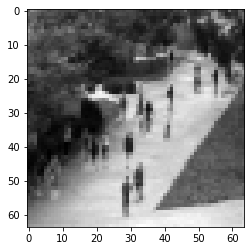

In [393]:
import imageio
from skimage import transform,io
import matplotlib.pyplot as plt
# read images and store into a np array

data_dir = '/kaggle/input/mlub-learning-to-count/train/'
im_size = 64
N = df_train.shape[0]
X = np.zeros((N, im_size,im_size))
y = np.zeros((N))
cont =0

for ind, item in df_train.iterrows():
    im       = imageio.imread(data_dir + item[0])/255.
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X[cont, :,:] = small_im
    y[cont] = item[1]
    cont+=1

plt.imshow(small_im,cmap='gray')
plt.show()

In [394]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import random
datagen = ImageDataGenerator(rotation_range=45)
data_augmentation = []
for im in range(len(X)):
    img = X[im]
    data = img_to_array(img)
    samples = expand_dims(data, 0)
    it = datagen.flow(samples, batch_size=1)
    label = y[im]
    # generate samples and plot
    for i in range(1):
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('float64')
        image = image[:,:,0]
        data_augmentation.append((image, label))

random.shuffle(data_augmentation)
listX = [x[0] for x in data_augmentation]
listy = [x[1] for x in data_augmentation]



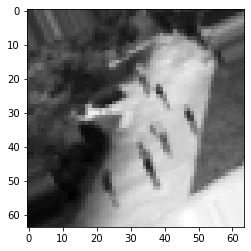

9.0


In [395]:
plt.imshow(listX[0], cmap='gray')
plt.show()

print(listy[0])

In [396]:
'''X = np.concatenate((X, listX))
y = np.concatenate((y, listy))'''

'X = np.concatenate((X, listX))\ny = np.concatenate((y, listy))'

In [397]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.3, random_state=66)

In [398]:
from sklearn.ensemble import RandomForestRegressor
# random forest model 
'''rfc = RandomForestRegressor()
rfc.fit(X_train.reshape((X_train.shape[0],-1)),y_train)
# predictions
rfc_predict = rfc.predict(X_val.reshape((X_val.shape[0],-1)))
'''

'rfc = RandomForestRegressor()\nrfc.fit(X_train.reshape((X_train.shape[0],-1)),y_train)\n# predictions\nrfc_predict = rfc.predict(X_val.reshape((X_val.shape[0],-1)))\n'

In [399]:
from sklearn.metrics import mean_squared_error
'''plt.plot(rfc_predict,y_val,'.')

print(np.sqrt(mean_squared_error(rfc_predict,y_val)))'''

"plt.plot(rfc_predict,y_val,'.')\n\nprint(np.sqrt(mean_squared_error(rfc_predict,y_val)))"

In [400]:
import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
history = {}

In [401]:
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

In [402]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

# create the model
model = keras.models.Sequential([
    DefaultConv2D(filters=32, kernel_size=3, input_shape=[64, 64, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=64, kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=30, activation='softmax')
])


In [403]:
model.layers

In [404]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0

In [405]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [406]:
history = model.fit(X_train, y_train, epochs=500,
                    validation_data=(X_val, y_val),verbose=1)

Epoch 1/500
11/11 [==============================] - 0s 22ms/step - loss: 3.5763 - accuracy: 0.0314 - val_loss: 3.4009 - val_accuracy: 0.0267
Epoch 2/500
11/11 [==============================] - 0s 8ms/step - loss: 3.4013 - accuracy: 0.0314 - val_loss: 3.4006 - val_accuracy: 0.0267
Epoch 3/500
11/11 [==============================] - 0s 8ms/step - loss: 3.4024 - accuracy: 0.0314 - val_loss: 3.4003 - val_accuracy: 0.0333
Epoch 4/500
11/11 [==============================] - 0s 8ms/step - loss: 3.3936 - accuracy: 0.0343 - val_loss: 3.4002 - val_accuracy: 0.0333
Epoch 5/500
11/11 [==============================] - 0s 8ms/step - loss: 3.3880 - accuracy: 0.0629 - val_loss: 3.3999 - val_accuracy: 0.0333
Epoch 6/500
11/11 [==============================] - 0s 8ms/step - loss: 3.3941 - accuracy: 0.0543 - val_loss: 3.3999 - val_accuracy: 0.0333
Epoch 7/500
11/11 [==============================] - 0s 8ms/step - loss: 3.3838 - accuracy: 0.0429 - val_loss: 3.4001 - val_accuracy: 0.0333
Epoch 8/500


Epoch 59/500
11/11 [==============================] - 0s 7ms/step - loss: 2.3290 - accuracy: 0.2171 - val_loss: 2.4555 - val_accuracy: 0.1533
Epoch 60/500
11/11 [==============================] - 0s 7ms/step - loss: 2.3342 - accuracy: 0.2143 - val_loss: 2.4987 - val_accuracy: 0.1533
Epoch 61/500
11/11 [==============================] - 0s 8ms/step - loss: 2.2766 - accuracy: 0.2229 - val_loss: 2.4204 - val_accuracy: 0.1467
Epoch 62/500
11/11 [==============================] - 0s 7ms/step - loss: 2.2895 - accuracy: 0.2000 - val_loss: 4.3098 - val_accuracy: 0.0267
Epoch 63/500
11/11 [==============================] - 0s 7ms/step - loss: 2.2562 - accuracy: 0.2514 - val_loss: 2.4181 - val_accuracy: 0.1933
Epoch 64/500
11/11 [==============================] - 0s 7ms/step - loss: 2.2459 - accuracy: 0.2229 - val_loss: 2.4510 - val_accuracy: 0.1800
Epoch 65/500
11/11 [==============================] - 0s 7ms/step - loss: 2.2424 - accuracy: 0.2257 - val_loss: 3.1349 - val_accuracy: 0.0533
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 1.8450 - accuracy: 0.3286 - val_loss: 2.8070 - val_accuracy: 0.1867
Epoch 117/500
11/11 [==============================] - 0s 8ms/step - loss: 1.7411 - accuracy: 0.4229 - val_loss: 2.6830 - val_accuracy: 0.1867
Epoch 118/500
11/11 [==============================] - 0s 8ms/step - loss: 1.7958 - accuracy: 0.3686 - val_loss: 2.6574 - val_accuracy: 0.1867
Epoch 119/500
11/11 [==============================] - 0s 8ms/step - loss: 1.7682 - accuracy: 0.4257 - val_loss: 2.7210 - val_accuracy: 0.1533
Epoch 120/500
11/11 [==============================] - 0s 8ms/step - loss: 1.7645 - accuracy: 0.3714 - val_loss: 3.1347 - val_accuracy: 0.1467
Epoch 121/500
11/11 [==============================] - 0s 7ms/step - loss: 1.6405 - accuracy: 0.4200 - val_loss: 2.9818 - val_accuracy: 0.1467
Epoch 122/500
11/11 [==============================] - 0s 8ms/step - loss: 1.7532 - accuracy: 0.4029 - val_loss: 4.0881 - val_accuracy: 0.1000
Epoch 123/500

11/11 [==============================] - 0s 8ms/step - loss: 1.2449 - accuracy: 0.5743 - val_loss: 3.4229 - val_accuracy: 0.1333
Epoch 174/500
11/11 [==============================] - 0s 8ms/step - loss: 1.2210 - accuracy: 0.5714 - val_loss: 3.3541 - val_accuracy: 0.1200
Epoch 175/500
11/11 [==============================] - 0s 8ms/step - loss: 1.2444 - accuracy: 0.5571 - val_loss: 3.1967 - val_accuracy: 0.1467
Epoch 176/500
11/11 [==============================] - 0s 8ms/step - loss: 1.2666 - accuracy: 0.5571 - val_loss: 3.2112 - val_accuracy: 0.1533
Epoch 177/500
11/11 [==============================] - 0s 8ms/step - loss: 1.3290 - accuracy: 0.5457 - val_loss: 3.6976 - val_accuracy: 0.1867
Epoch 178/500
11/11 [==============================] - 0s 8ms/step - loss: 1.1878 - accuracy: 0.5743 - val_loss: 3.1792 - val_accuracy: 0.1333
Epoch 179/500
11/11 [==============================] - 0s 8ms/step - loss: 1.2405 - accuracy: 0.5829 - val_loss: 2.9382 - val_accuracy: 0.1667
Epoch 180/500

11/11 [==============================] - 0s 7ms/step - loss: 0.9976 - accuracy: 0.6629 - val_loss: 3.9004 - val_accuracy: 0.1467
Epoch 231/500
11/11 [==============================] - 0s 8ms/step - loss: 0.8939 - accuracy: 0.7000 - val_loss: 3.6757 - val_accuracy: 0.1467
Epoch 232/500
11/11 [==============================] - 0s 8ms/step - loss: 1.0296 - accuracy: 0.6543 - val_loss: 3.5666 - val_accuracy: 0.1400
Epoch 233/500
11/11 [==============================] - 0s 8ms/step - loss: 0.9220 - accuracy: 0.6914 - val_loss: 3.6381 - val_accuracy: 0.1400
Epoch 234/500
11/11 [==============================] - 0s 8ms/step - loss: 0.8349 - accuracy: 0.7057 - val_loss: 3.7911 - val_accuracy: 0.1667
Epoch 235/500
11/11 [==============================] - 0s 7ms/step - loss: 0.8537 - accuracy: 0.7171 - val_loss: 3.7490 - val_accuracy: 0.1600
Epoch 236/500
11/11 [==============================] - 0s 7ms/step - loss: 0.8715 - accuracy: 0.6971 - val_loss: 4.4162 - val_accuracy: 0.1333
Epoch 237/500

11/11 [==============================] - 0s 8ms/step - loss: 0.8527 - accuracy: 0.7086 - val_loss: 4.6218 - val_accuracy: 0.1133
Epoch 288/500
11/11 [==============================] - 0s 7ms/step - loss: 0.8179 - accuracy: 0.7257 - val_loss: 4.4147 - val_accuracy: 0.1400
Epoch 289/500
11/11 [==============================] - 0s 8ms/step - loss: 0.9194 - accuracy: 0.6943 - val_loss: 3.9558 - val_accuracy: 0.1733
Epoch 290/500
11/11 [==============================] - 0s 8ms/step - loss: 0.7936 - accuracy: 0.7514 - val_loss: 3.9911 - val_accuracy: 0.1667
Epoch 291/500
11/11 [==============================] - 0s 8ms/step - loss: 0.8244 - accuracy: 0.7314 - val_loss: 3.9908 - val_accuracy: 0.1533
Epoch 292/500
11/11 [==============================] - 0s 8ms/step - loss: 0.7562 - accuracy: 0.7343 - val_loss: 4.0918 - val_accuracy: 0.1667
Epoch 293/500
11/11 [==============================] - 0s 7ms/step - loss: 0.8059 - accuracy: 0.7314 - val_loss: 4.1167 - val_accuracy: 0.1400
Epoch 294/500

11/11 [==============================] - 0s 7ms/step - loss: 0.6522 - accuracy: 0.7829 - val_loss: 4.1159 - val_accuracy: 0.1867
Epoch 345/500
11/11 [==============================] - 0s 7ms/step - loss: 0.7448 - accuracy: 0.7429 - val_loss: 4.3772 - val_accuracy: 0.1800
Epoch 346/500
11/11 [==============================] - 0s 7ms/step - loss: 0.6402 - accuracy: 0.7829 - val_loss: 4.4776 - val_accuracy: 0.1800
Epoch 347/500
11/11 [==============================] - 0s 7ms/step - loss: 0.7120 - accuracy: 0.7771 - val_loss: 4.2705 - val_accuracy: 0.1667
Epoch 348/500
11/11 [==============================] - 0s 7ms/step - loss: 0.6016 - accuracy: 0.7914 - val_loss: 3.8864 - val_accuracy: 0.1733
Epoch 349/500
11/11 [==============================] - 0s 7ms/step - loss: 0.7446 - accuracy: 0.7629 - val_loss: 3.8456 - val_accuracy: 0.1733
Epoch 350/500
11/11 [==============================] - 0s 8ms/step - loss: 0.7107 - accuracy: 0.7486 - val_loss: 3.9774 - val_accuracy: 0.1600
Epoch 351/500

11/11 [==============================] - 0s 8ms/step - loss: 0.4719 - accuracy: 0.8429 - val_loss: 4.8447 - val_accuracy: 0.1467
Epoch 402/500
11/11 [==============================] - 0s 7ms/step - loss: 0.6790 - accuracy: 0.7771 - val_loss: 5.3776 - val_accuracy: 0.1200
Epoch 403/500
11/11 [==============================] - 0s 7ms/step - loss: 0.5681 - accuracy: 0.8000 - val_loss: 4.9368 - val_accuracy: 0.1600
Epoch 404/500
11/11 [==============================] - 0s 7ms/step - loss: 0.6128 - accuracy: 0.8086 - val_loss: 4.7219 - val_accuracy: 0.1600
Epoch 405/500
11/11 [==============================] - 0s 7ms/step - loss: 0.5379 - accuracy: 0.8229 - val_loss: 5.3164 - val_accuracy: 0.1533
Epoch 406/500
11/11 [==============================] - 0s 7ms/step - loss: 0.5351 - accuracy: 0.8057 - val_loss: 4.7001 - val_accuracy: 0.1867
Epoch 407/500
11/11 [==============================] - 0s 8ms/step - loss: 0.5747 - accuracy: 0.7943 - val_loss: 5.1445 - val_accuracy: 0.1667
Epoch 408/500

11/11 [==============================] - 0s 8ms/step - loss: 0.5498 - accuracy: 0.8343 - val_loss: 4.9081 - val_accuracy: 0.1800
Epoch 459/500
11/11 [==============================] - 0s 8ms/step - loss: 0.5231 - accuracy: 0.8257 - val_loss: 5.9144 - val_accuracy: 0.1600
Epoch 460/500
11/11 [==============================] - 0s 8ms/step - loss: 0.4421 - accuracy: 0.8429 - val_loss: 5.4377 - val_accuracy: 0.1467
Epoch 461/500
11/11 [==============================] - 0s 8ms/step - loss: 0.4846 - accuracy: 0.8486 - val_loss: 5.1376 - val_accuracy: 0.1733
Epoch 462/500
11/11 [==============================] - 0s 8ms/step - loss: 0.5326 - accuracy: 0.8457 - val_loss: 4.8200 - val_accuracy: 0.1933
Epoch 463/500
11/11 [==============================] - 0s 8ms/step - loss: 0.5047 - accuracy: 0.8371 - val_loss: 5.6705 - val_accuracy: 0.1533
Epoch 464/500
11/11 [==============================] - 0s 8ms/step - loss: 0.3953 - accuracy: 0.8743 - val_loss: 6.3456 - val_accuracy: 0.1733
Epoch 465/500

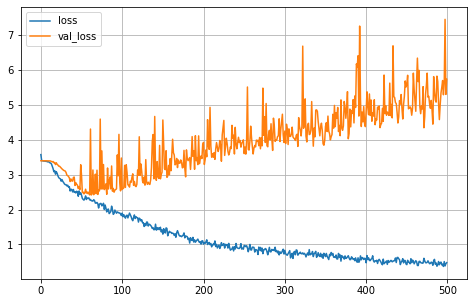

In [407]:
import pandas as pd

pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0.4, 0.8)
plt.show()

[29.  1. 20. 17. 24. 15.  9.  6.  7. 23. 19.  7. 21. 22. 13.  4. 15.  7.
 22. 25. 19. 26. 22. 21.  3.  9. 27. 27. 18. 28.  0.  8.  5. 20. 21.  5.
  6.  7.  3.  6.  3. 21. 23. 15.  4.  9. 29. 27.  4. 18. 19.  7.  2.  2.
  5. 11.  1.  8. 26. 26. 12. 20.  3.  3. 27. 26.  5. 27. 18. 28. 25.  3.
  3.  3.  1. 14.  5.  0.  5. 21. 10.  7. 10. 22. 28. 25. 10. 12. 25. 20.
  2. 28.  8.  7. 28. 15.  4.  6. 15.  3. 16.  7.  3. 18.  4. 22. 19. 21.
 24.  0.  3. 19. 15. 17. 16. 23. 23. 15.  3. 15. 12. 17. 26. 25. 12.  0.
  4. 13. 18.  0.  0. 21.  0. 24. 22. 15. 26. 23. 29. 25. 17.  7. 23.  0.
  4.  5. 13. 14. 25.  2.]
[26, 0, 20, 19, 26, 14, 6, 8, 6, 25, 18, 10, 19, 19, 18, 6, 10, 6, 18, 19, 8, 23, 25, 26, 6, 7, 18, 11, 18, 25, 0, 11, 7, 26, 9, 6, 5, 6, 3, 6, 7, 19, 19, 14, 3, 10, 25, 29, 2, 26, 18, 6, 3, 2, 4, 9, 0, 6, 29, 18, 10, 14, 3, 6, 19, 18, 10, 24, 18, 19, 16, 6, 2, 2, 1, 18, 6, 0, 5, 17, 3, 8, 11, 29, 27, 16, 11, 6, 19, 20, 2, 25, 8, 10, 26, 14, 8, 10, 18, 3, 17, 10, 6, 19, 7, 18, 26, 16, 26

4.368065933568311

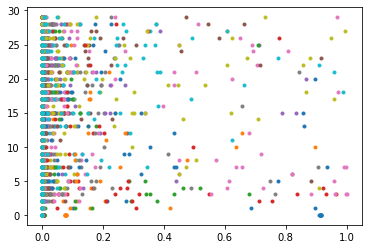

In [408]:
y_model1 = model.predict(X_val)
plt.plot(y_model1,y_val,'.')
print(y_val)
y_model_output = []
for i in y_model1:
    y_model_output.append(np.argmax(i))
print(y_model_output)
np.sqrt(mean_squared_error(y_model_output,y_val))

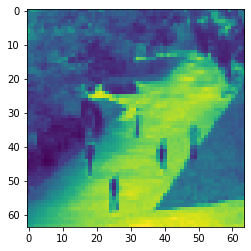

In [409]:
## evaluate test and generate submission
test_dir = '/kaggle/input/mlub-learning-to-count/test/test/'
im_size = 64
N = 500
X_test = np.zeros((N, im_size,im_size))
cont =0

for x in range(500):
    im       = imageio.imread(test_dir + 'test_composite'+str(x).zfill(9) + '.png')/255.
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X_test[cont, :,:] = small_im
    cont+=1
    
plt.imshow(small_im)
plt.show()

In [410]:
X_test = X_test[..., np.newaxis]

In [411]:
# create the file to make the sumbission

y_test = model.predict(X_test)
print(y_test)
y_test = [np.argmax(x) for x in y_test]

df_output = pd.DataFrame(y_test)
df_output.index.name = 'index'
df_output.columns = ['prediction']
df_output.to_csv('output.csv')


[[7.22052756e-12 3.83800528e-16 5.03936086e-14 ... 4.21942204e-05
  1.32489613e-05 8.13693643e-01]
 [4.26309228e-08 7.35606784e-11 1.19493770e-09 ... 7.73084594e-06
  7.80730807e-06 2.14666175e-03]
 [1.74498012e-07 4.93041352e-06 1.33498386e-03 ... 1.23034312e-07
  4.37093313e-08 7.84004459e-11]
 ...
 [8.80978350e-03 3.03107947e-01 5.91323040e-02 ... 5.63503888e-17
  1.71965664e-12 2.12768019e-16]
 [3.25288396e-09 1.08080265e-07 5.09607707e-05 ... 1.01502913e-08
  3.01095748e-09 1.87947033e-10]
 [8.64516405e-05 2.23833820e-04 8.58991698e-04 ... 2.66957206e-10
  9.79516912e-09 1.21931501e-11]]


In [412]:
print(y_test)

[29, 18, 8, 18, 25, 8, 19, 17, 0, 10, 15, 2, 3, 18, 19, 3, 10, 2, 25, 13, 1, 19, 20, 9, 18, 0, 7, 6, 6, 1, 8, 10, 18, 11, 18, 0, 9, 6, 7, 7, 9, 10, 11, 14, 18, 14, 10, 26, 2, 23, 18, 2, 14, 7, 1, 27, 4, 19, 19, 25, 26, 13, 11, 1, 6, 13, 0, 6, 10, 14, 14, 2, 0, 15, 27, 8, 6, 11, 17, 26, 7, 11, 29, 18, 2, 19, 23, 28, 11, 18, 17, 25, 26, 3, 28, 24, 19, 18, 0, 5, 10, 18, 14, 19, 18, 6, 18, 26, 6, 6, 26, 19, 16, 28, 20, 9, 10, 3, 2, 10, 25, 6, 3, 19, 14, 8, 6, 18, 3, 18, 18, 20, 4, 10, 18, 10, 2, 18, 11, 2, 11, 3, 14, 18, 0, 18, 25, 19, 20, 10, 8, 14, 19, 25, 7, 2, 16, 19, 19, 25, 0, 11, 10, 10, 14, 19, 18, 18, 19, 6, 10, 10, 14, 12, 6, 18, 26, 23, 1, 28, 3, 18, 6, 16, 6, 14, 22, 26, 28, 11, 14, 9, 29, 18, 18, 10, 10, 18, 8, 18, 25, 5, 28, 10, 18, 27, 18, 19, 18, 2, 26, 18, 9, 23, 25, 14, 11, 2, 12, 0, 8, 0, 25, 24, 23, 6, 22, 14, 10, 0, 26, 26, 6, 26, 10, 8, 18, 18, 8, 0, 10, 10, 6, 2, 10, 29, 7, 6, 18, 10, 7, 18, 11, 0, 6, 7, 28, 0, 28, 8, 26, 0, 29, 18, 1, 2, 0, 7, 10, 3, 8, 6, 18, 18, 2